In [293]:
from platform import python_version
print("python-version:", python_version())
import numpy as np
import pandas as pd
import tensorflow as tf
print("tensorflow:",tf.__version__)
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import norm
import collections

python-version: 3.9.7
tensorflow: 2.8.0


# Time Serie

In [343]:
dates=np.arange(datetime(2020,1,1), datetime(2022,12,31), timedelta(days=1)).astype(datetime)

In [348]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    # return np.where(season_time < 0.4,
    #                 np.cos(season_time * 2 * np.pi),
    #                 1 / np.exp(3 * season_time))
    return np.cos(season_time *4*  np.pi) + 0.5*np.cos(season_time *2*np.pi)


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


In [442]:
def plot_series(x, y, color=None,label=None):
    plt.plot(x,y,color=color,label=label)
    plt.grid(True)

In [349]:
f=lambda x: x.toordinal()
date_idx = np.array([f(date) for date in dates])

In [351]:
labels = 10+seasonality(date_idx,phase=230,amplitude=10,period=365)+noise(time=date_idx,noise_level=2,seed=1)

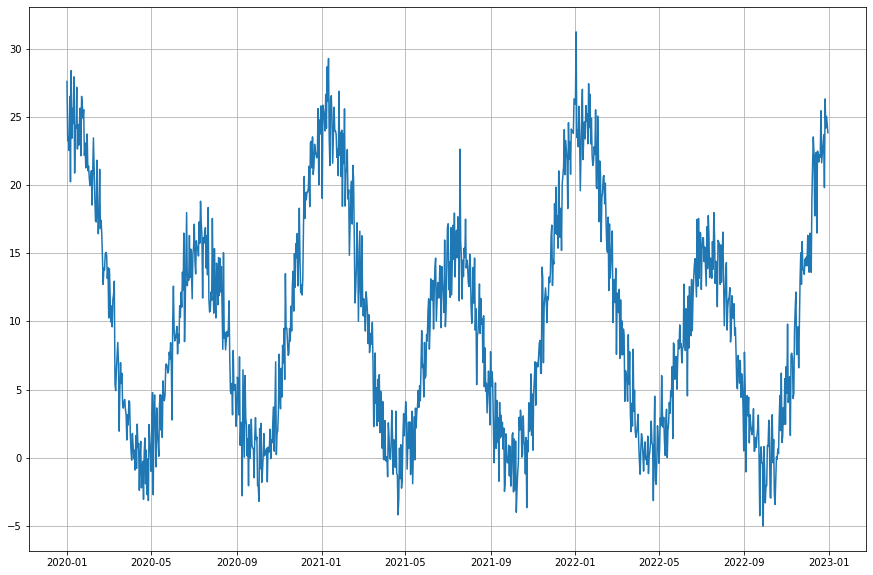

In [435]:
plt.figure(figsize=(15,10))
plot_series(dates,labels)

# Seasonality Feature

In [ ]:
def _get_anchors(num_splits, year, shift):
    anchors=[]
    for idx in range(num_splits):
        month = 1 +idx * (12//num_splits) + shift
        anchors.append(datetime(year,month,1))
    return anchors

In [ ]:
anchors_2021 =_get_anchors(4,2021,2)

In [7]:
def _get_day_index(date):
    return int(date.strftime('%j'))

In [106]:
def _get_month(date):
    return int(date.strftime('%m'))

In [138]:
def _get_day_month(date):
    return date.strftime('%m-%d')

In [268]:
def _min_max_scaling(values):
    min_value= min(values)
    max_value=max(values)
    values_scaled = (values-min_value)/(max_value-min_value)
    return values_scaled

In [253]:
def _get_gaussian_values(x_values, mean, variance=30, period=365):
    values = norm.pdf(np.array(x_values)-period, mean, variance)+ norm.pdf(np.array(x_values), mean, variance)+ norm.pdf(np.array(x_values)+period, mean, variance)
    return  values

In [388]:
def create_seasonality_feature(input_date, anchors):
    """
    create seasonality feature per input-date
    The feature is of shape len(anchors)
    Anchors define the reference points with which the input is compared.
    """
    reference_day_idx=_get_day_index(input_date)
    first_day_of_year=datetime(input_date.year, 1,1)
    last_day_of_year=datetime(input_date.year,12,31)
    period = (last_day_of_year-first_day_of_year).days

    variance = (anchors[1]-anchors[0]).days/2

    # Create the seasonality value for each day in this year
    dates = np.arange(first_day_of_year,last_day_of_year,timedelta(days=1)).astype(datetime)
    x_values =  [_get_day_index(date) for date in dates]
    values = _get_gaussian_values(x_values,mean=reference_day_idx, variance=variance, period=period )
    values_scaled = _min_max_scaling(values)

    tuples = list(zip(dates, values_scaled))
    
    num_anchors = len(anchors)
    sorted_anchors = sorted(anchors)
    anchors_dct = collections.defaultdict(list)
    
    # Link each value to an anchor; here we use the maximal anchor which is smaller than the date
    for tuple in tuples:
        date = tuple[0]
        value_scaled = tuple[1]

        for anchor_idx in range(num_anchors-1):
            if (date >= sorted_anchors[anchor_idx] and date < sorted_anchors[anchor_idx+1]):
                 anchors_dct[sorted_anchors[anchor_idx]].append(value_scaled)
            # case if date is bigger than the last anchor, or smaller than the first anchor --> link value to the last anchor.                 
            elif (date >= sorted_anchors[num_anchors-1] or  date < sorted_anchors[0]):
                
                anchors_dct[sorted_anchors[num_anchors-1]].append(value_scaled)

    features=[]
    # aggregate all values per anchor
    for anchor, vals in anchors_dct.items():
        features.append(sum(vals)/ float(len(vals)))        
        
    
    return features, dates, values_scaled




In [472]:
example_date_1 = datetime(2021,4,15)
example_date_2 = datetime(2021,5,10)
example_date_3 = datetime(2021,12,10)

In [473]:
features_1, days_1, gauss_values_1 = create_seasonality_feature(example_date_1,anchors_2021)
features_2, days_2, gauss_values_2 = create_seasonality_feature(example_date_2,anchors_2021)
features_3, days_3, gauss_values_3 = create_seasonality_feature(example_date_3,anchors_2021)

In [474]:
features_1

[0.20609578186167296,
 0.8554852377451683,
 0.19328547276218946,
 0.0030434008720270135]

In [475]:
features_2

[0.08014052479221383,
 0.7733783798000481,
 0.3921817128766948,
 0.00815762855992212]

In [476]:
features_3

[0.6991583889803064,
 0.05173943671161503,
 0.017430602272413154,
 0.5111828486367301]

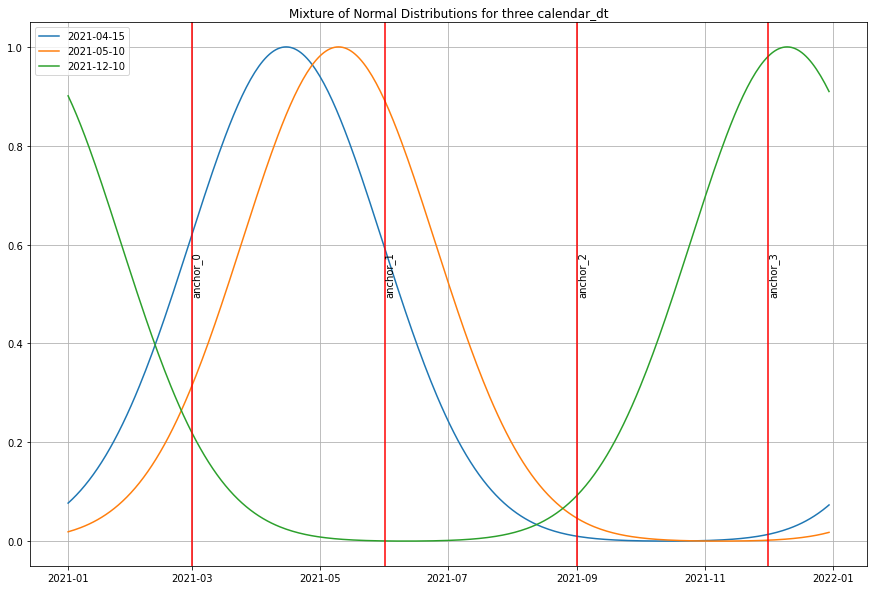

In [479]:
plt.figure(figsize=(15,10))
plot_series(days_1, gauss_values_1, label=str(example_date_1.date()))
plot_series(days_2, gauss_values_2,label=str(example_date_2.date()))
plot_series(days_3, gauss_values_3,label=str(example_date_3.date()))
for idx, anchor in enumerate(anchors_2021):
    plt.axvline(anchor, color='red')
    plt.text(anchor,0.5,'anchor_'+str(idx), rotation=90)
plt.title('Mixture of Normal Distributions for three calendar_dt')
plt.legend()


In [478]:
features =[]
for date in dates:
    anchors =_get_anchors(4, date.year, shift=2)
    seasonal_feature ,a,b = create_seasonality_feature(date, anchors)
    features.append(seasonal_feature)

features = np.array(features)

# Train a Simple DNN using these Seasonality Features

In [394]:
split_time = 720
train_features = features[:split_time]
train_labels = labels[:split_time]
test_features = features[split_time:]
test_labels=labels[split_time:]

In [415]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
train_dataset=train_dataset.shuffle(100).batch(10)
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
test_dataset = test_dataset.batch(10)

In [417]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5,activation='relu'),
    tf.keras.layers.Dense(1,  activation='linear') 
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              )

In [419]:
history=model.fit(train_dataset, epochs=100, verbose=0)

In [420]:
predictions=model.predict(test_dataset)

In [423]:
def plot_series(x, y, color=None):
    plt.plot(x,y,color=color)
    plt.grid(True)

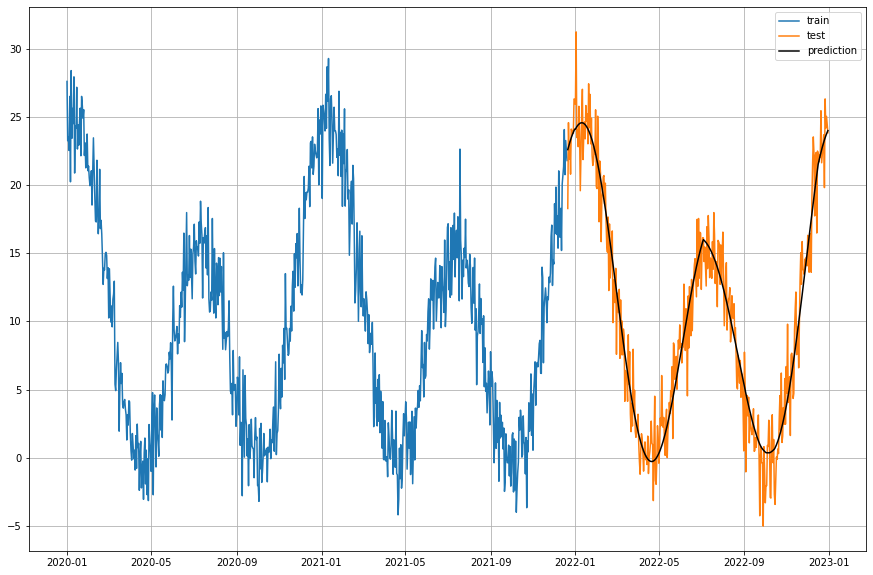

In [444]:
# Plot Train, Test and Predictions
plt.figure(figsize=(15,10))
plot_series(dates[:split_time],train_labels, label='train' )
plot_series(dates[split_time:],test_labels,label='test')
plot_series(dates[split_time:], predictions[:,0],color='black',label='prediction')
plt.legend()